# コードのテスト
## roc_curve.py の関数について
- ROC図作成

In [1]:
import os
gpu_num = "0"
os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_num)

# モジュールimport
import os, sys
current_dir = os.path.dirname(os.path.abspath("__file__"))
path = os.path.join(current_dir, '../../')
sys.path.append(path)
from dataset import plot_log, prepare_data, util, plot_12task_log
from transformer import get_train_valid_test
from model import define_model, multi_loss, my_callback, my_metric
from predicter import roc_curve, conf_matrix, multi_predict, grad_cam, ensemble_predict

import numpy as np
import keras
import keras.backend as K
import matplotlib.pyplot as plt

sys.path.append(r'/home/tmp10014/jupyterhub/notebook/other/lib_DL/mixup-generator')
from random_eraser import get_random_eraser

plot_log.py: loaded as module file
prepare_data.py: loaded as module file
util.py: loaded as module file
plot_12task_log.py: loaded as module file


Using TensorFlow backend.
/home/tmp10014/.conda/envs/py36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


get_train_valid_test.py: loaded as module file
define_model.py: loaded as module file
multi_loss.py: loaded as module file
my_callback.py: loaded as module file
my_metric.py: loaded as module file
roc_curve.py: loaded as module file
conf_matrix.py: loaded as module file
multi_predict.py: loaded as module file
grad_cam.py: loaded as module file
ensemble_predict.py: loaded as module file


In [2]:
%%time
train_batch_size=68#17
valid_batch_size=37#6
shape=[100, 100, 3]
out_dir='output_test/100x100'

# ラベル情報などが書いたcsvファイル（tox21_compoundData.csv）
csv_path = r'../../storage/tox21_compoundData.csv'
# IDにファイルのフルパスつける
img_dir = r'../../storage/img/Wash/100x100/'
# 画像ファイルのサフィックス
img_suffix = r'_000.jpg'
# 欠損値を-1に置換したtox21_compoundData.csvのデータフレーム
df = prepare_data.make_label_df(csv_path, img_dir, img_suffix=img_suffix)
# Tox21の画像のパスとラベル(y_train,y_valid,y_test)を取得する
train_files, validation_files, test_files, y_train, y_valid, y_test = prepare_data.make_train_val_test(df)

d_cls = get_train_valid_test.LabeledDataset(shape, train_batch_size, valid_batch_size)
d_cls.load_train_as_image(train_files, y_train)
d_cls.load_validation_as_image(validation_files, y_valid)
d_cls.load_test_as_image(test_files, y_test)

training_set_y.shape: (11764, 12)
validation_set_y.shape: (296, 12)
test_set_y.shape: (647, 12)
CPU times: user 7.46 s, sys: 2.62 s, total: 10.1 s
Wall time: 17.4 s


## roc_curve.plot_roc
###  test_model.h5

------------------------------------
out_png: output_test/100x100/predict/test/ROC_curve.png


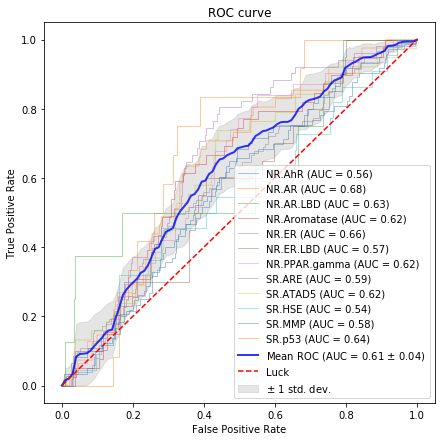

CPU times: user 27.2 s, sys: 4.33 s, total: 31.5 s
Wall time: 30 s


<Figure size 432x288 with 0 Axes>

In [3]:
%%time
# -------- 推論 --------
model = keras.models.load_model(os.path.join(out_dir, 'test_model.h5'), compile=False)
# 推論結果出力先
out_predict_dir = os.path.join(out_dir, 'predict/test')
# 出力層のニューラルネットワークに分岐がない場合のpredict
y_test_list, y_pred_list = multi_predict.no_branch_set_predict(model, d_cls.X_test, d_cls.y_test, out_predict_dir)

# -------- ROC_AUC --------
# タスクごとのpredictのスコア(y_pred)と正解ラベル(y_true)からROC_AUCファイル出力
roc_curve.plot_roc(os.path.join(out_predict_dir, 'ROC_curve.png'), y_test_list, y_pred_list)

(610, 2)
(516, 2)
(610, 2)
(616, 2)


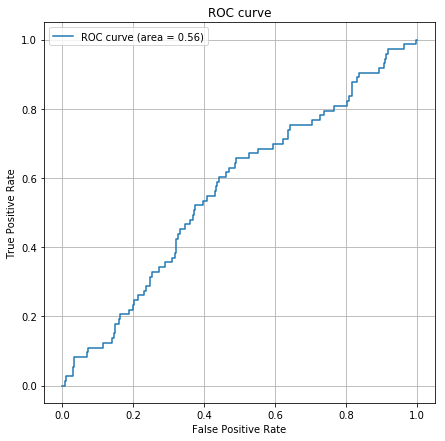

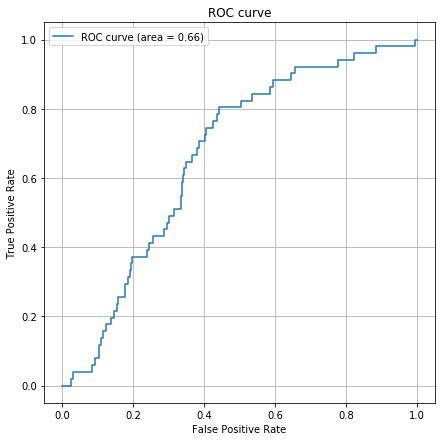

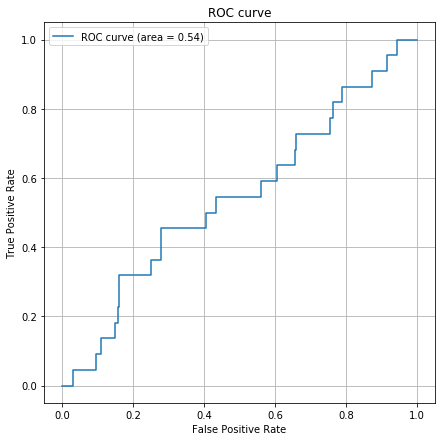

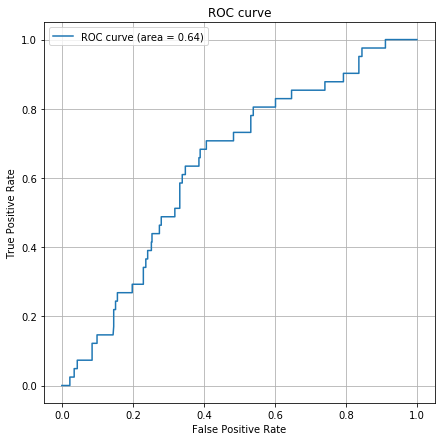

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
%matplotlib inline

def roc_mask_plot(y_true, y_pred):
    y_df = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred})
    y_df = y_df[y_df['y_true'] != -1.0]# 欠損ラベル=-1.0 以外の行だけにする
    print(y_df.shape)
    y_true = np.array(y_df['y_true'])
    y_pred = np.array(y_df['y_pred'])

    # https://qiita.com/9pid/items/53946c3ec4b2489e7cb2
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
    auc = metrics.auc(fpr, tpr)
    # ROC曲線をプロット
    plt.figure(figsize=(7, 7))
    plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%auc)
    plt.legend()
    plt.title('ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(True)
    
    return y_df
    
y_df = roc_mask_plot(y_test_list[0], y_pred_list[0])
y_df = roc_mask_plot(y_test_list[4], y_pred_list[4])
y_df = roc_mask_plot(y_test_list[9], y_pred_list[9])
y_df = roc_mask_plot(y_test_list[11], y_pred_list[11])

###  test_model_12branch.h5

------------------------------------
out_png: output_test/100x100/predict/validation/ROC_curve.png


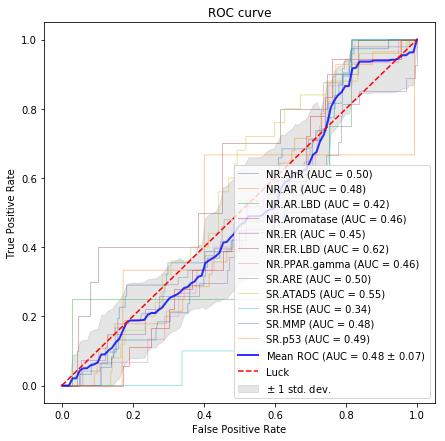

CPU times: user 8.93 s, sys: 1.09 s, total: 10 s
Wall time: 9.42 s


<Figure size 432x288 with 0 Axes>

In [5]:
%%time
# -------- 推論 --------
model = keras.models.load_model(os.path.join(out_dir, 'test_model_12branch.h5'), compile=False)
# 推論結果出力先
out_predict_dir = os.path.join(out_dir, 'predict/validation')
# 出力層のニューラルネットワークに分岐がない場合のpredict
y_valid_list, y_pred_list = multi_predict.branch_set_predict(model, d_cls.X_valid, d_cls.y_valid, out_predict_dir)

# -------- ROC_AUC --------
# タスクごとのpredictのスコア(y_pred)と正解ラベル(y_true)からROC_AUCファイル出力
roc_curve.plot_roc(os.path.join(out_predict_dir, 'ROC_curve.png'), y_valid_list, y_pred_list)

(272, 2)
(265, 2)
(267, 2)
(269, 2)


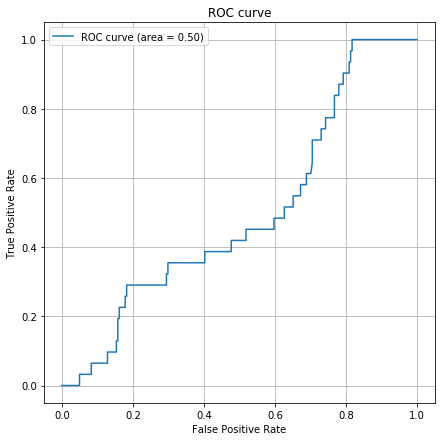

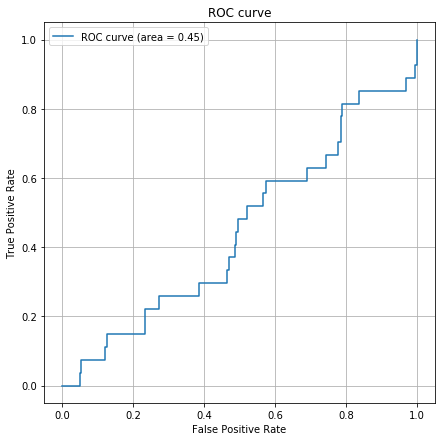

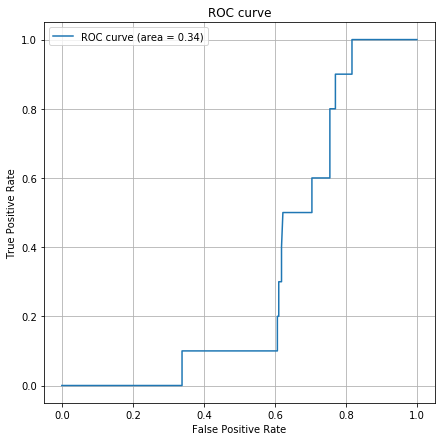

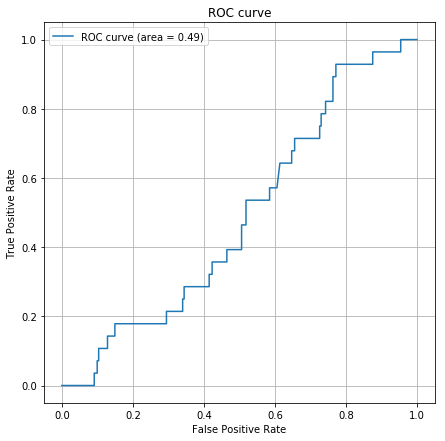

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
%matplotlib inline

def roc_mask_plot(y_true, y_pred):
    y_df = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred})
    y_df = y_df[y_df['y_true'] != -1.0]# 欠損ラベル=-1.0 以外の行だけにする
    print(y_df.shape)
    y_true = np.array(y_df['y_true'])
    y_pred = np.array(y_df['y_pred'])

    # https://qiita.com/9pid/items/53946c3ec4b2489e7cb2
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
    auc = metrics.auc(fpr, tpr)
    # ROC曲線をプロット
    plt.figure(figsize=(7, 7))
    plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%auc)
    plt.legend()
    plt.title('ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(True)
    
    return y_df
    
y_df = roc_mask_plot(y_valid_list[0], y_pred_list[0])
y_df = roc_mask_plot(y_valid_list[4], y_pred_list[4])
y_df = roc_mask_plot(y_valid_list[9], y_pred_list[9])
y_df = roc_mask_plot(y_valid_list[11], y_pred_list[11])